# Import libraries and Packages

In [35]:
#all libraries used
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

# Loading the dataset and visualization of data and preprocessing

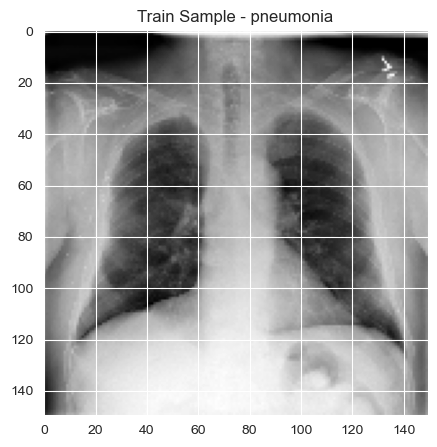

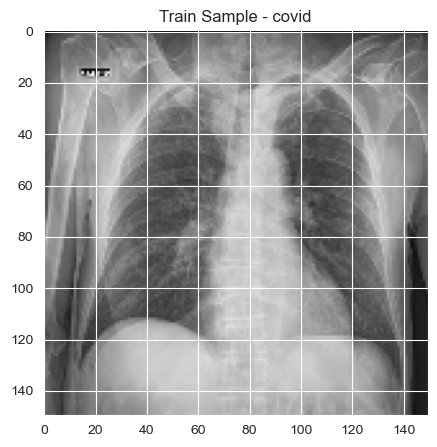

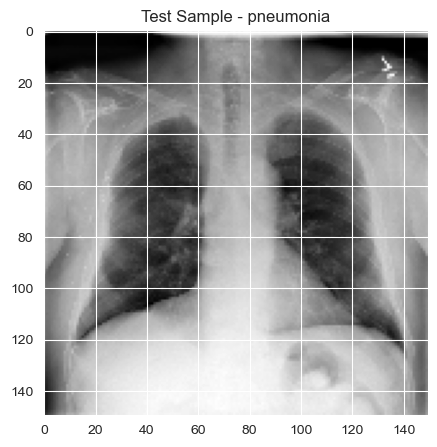

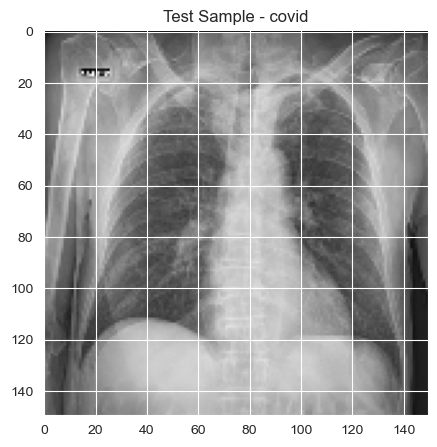

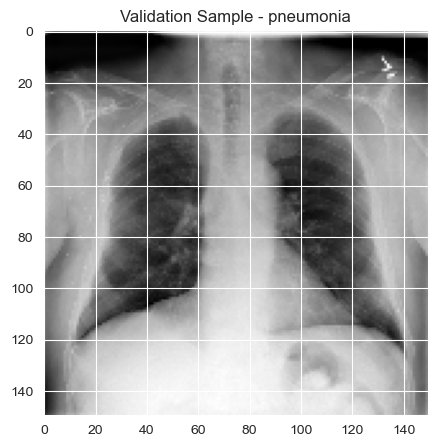

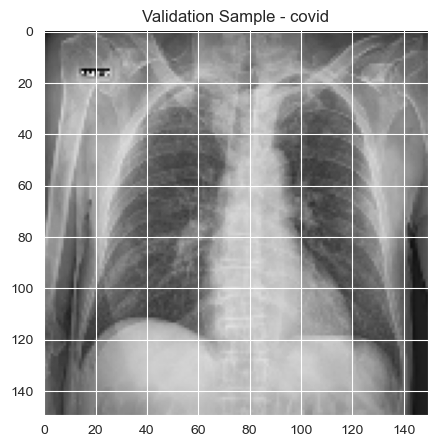

Data type of images: uint8


In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

labels = ['pneumonia', 'normal','covid']
img_size = 150

def load_and_preprocess_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (img_size, img_size))
                data.append([img_resized, class_num])
    return np.array(data, dtype=object)

train_data_dir = r'C:\Users\hp pc\Downloads\DataSet'
test_data_dir = r'C:\Users\hp pc\Downloads\DataSet'
val_data_dir = r'C:\Users\hp pc\Downloads\DataSet'

train = load_and_preprocess_data(train_data_dir)
test = load_and_preprocess_data(test_data_dir)
val = load_and_preprocess_data(val_data_dir)

data = load_and_preprocess_data(train_data_dir)

# Split data into features and labels
X = np.array([i[0] for i in data]).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in data])

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

def display_sample_images(data, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[0][0], cmap='gray')
    plt.title(f"{title} - {labels[data[0][1]]}")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(data[-1][0], cmap='gray')
    plt.title(f"{title} - {labels[data[-1][1]]}")
    plt.show()

# Ensure plots are shown immediately if running in interactive environment
%matplotlib inline

display_sample_images(train, 'Train Sample')
display_sample_images(test, 'Test Sample')
display_sample_images(val, 'Validation Sample')

# Accessing the dtype of an image
img_dtype = train[0][0].dtype
print("Data type of images:", img_dtype)


In [37]:
l = ["Pneumonia" if i[1] == 0 else "Normal" if i[1] == 1 else "COVID" for i in train]
print("Sample labels from l:", l[:10])
l_series = pd.Series(l)

Sample labels from l: ['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


In [38]:
sns.set_style('darkgrid')

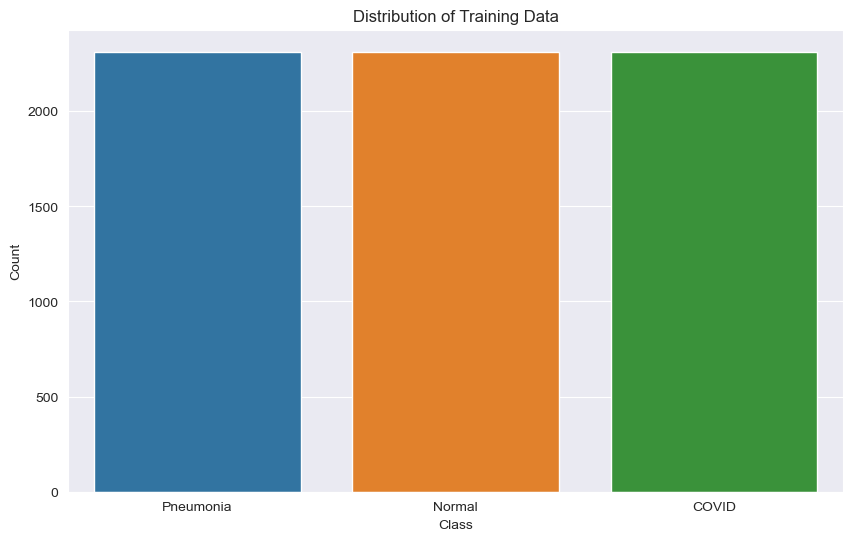

In [39]:
# Plot the distribution of the training data
plt.figure(figsize=(10, 6))  # Optional: Set the figure size for better visualization
sns.countplot(x=l_series)
plt.title('Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Reshaping images and Augmentation

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

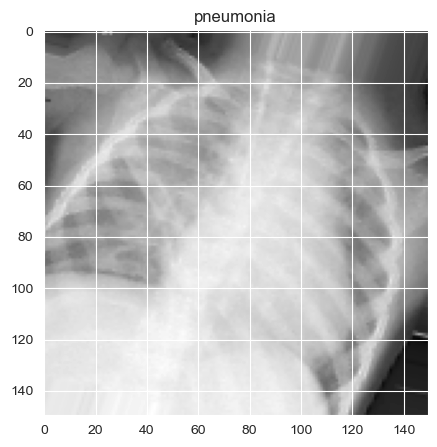

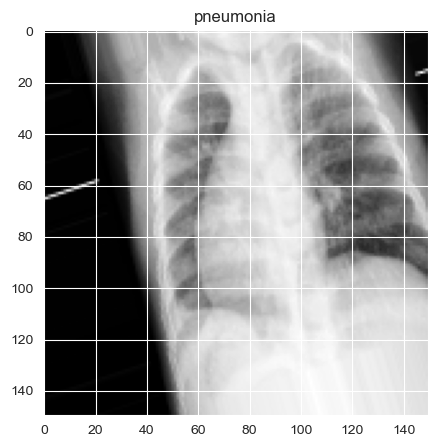

In [41]:
# Apply data augmentation to the training data
# Convert the list to numpy array and then to a format that can be used by ImageDataGenerator
train_images = np.array([item[0] for item in train]).reshape(-1, img_size, img_size, 1)
train_labels = np.array([item[1] for item in train])

# Fit the data generator to the training data
datagen.fit(train_images)

# Display augmented images
augmented_images, augmented_labels = next(datagen.flow(train_images, train_labels, batch_size=1))

plt.figure(figsize=(5, 5))
plt.imshow(augmented_images[0].reshape(img_size, img_size), cmap='gray')
plt.title(labels[augmented_labels[0]])
plt.show()

augmented_images, augmented_labels = next(datagen.flow(train_images, train_labels, batch_size=1))

plt.figure(figsize=(5, 5))
plt.imshow(augmented_images[0].reshape(img_size, img_size), cmap='gray')
plt.title(labels[augmented_labels[0]])
plt.show()

In [42]:
import os
import cv2
import numpy as np
from scipy import ndimage

# Function for diaphragm removal and reprocessing
def process_image(image_path, save_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the maximum and minimum pixel values
    vmax = np.max(gray)
    vmin = np.min(gray)

    # Calculate the threshold
    T = vmin + 0.9 * (vmax - vmin)

    # Threshold the grayscale image
    _, binary = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)

    # Find all connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Identify the largest connected component
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a binary image with only the largest connected component
    binary_largest = np.zeros_like(binary)
    binary_largest[labels == largest_label] = 255

    # Fill holes in the largest connected component
    filled_binary = ndimage.binary_fill_holes(binary_largest).astype('uint8') * 255

    # Apply morphological operations to smooth the boundary of the region
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    smooth_binary = cv2.morphologyEx(filled_binary, cv2.MORPH_OPEN, kernel)

    # Map the processed binary image back to the original image
    img[smooth_binary != 0] = 0

    # Split the image into channels
    r, g, b = cv2.split(img)
    
    # Apply bilateral filtering to the blue channel
    bilat_b = cv2.bilateralFilter(b, 9, 75, 75)
    
    # Perform histogram equalization on the red channel
    equalized_r = cv2.equalizeHist(r)

    # Merge the equalized red channel with bilat_b and green
    result = cv2.merge([equalized_r, g, bilat_b])

    # Resize the image to 224x224
    result = cv2.resize(result, (224, 224))

    # Save the processed image with the .jpg extension
    file_name = os.path.splitext(os.path.basename(image_path))[0] + '.jpg'
    cv2.imwrite(os.path.join(save_path, file_name), result)

# Main function to process images in the dataset
def process_dataset(dataset_path, save_path):
    # Create the save path if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Iterate through subfolders (pneumonia, normal, covid)
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if os.path.isdir(subfolder_path):
            subfolder_save_path = os.path.join(save_path, subfolder)
            os.makedirs(subfolder_save_path, exist_ok=True)
            
            # Iterate through images in the subfolder
            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                
                # Process the image and save the result
                process_image(image_path, subfolder_save_path)

# Path to the dataset folder containing subfolders (pneumonia, normal, covid)
dataset_path = r'C:\Users\hp pc\Downloads\DataSet'

# Path to the folder where processed images will be saved
save_path = r'C:\Users\hp pc\Downloads\ProcessedImages01'

# Process images in the dataset
process_dataset(dataset_path, save_path)


In [43]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


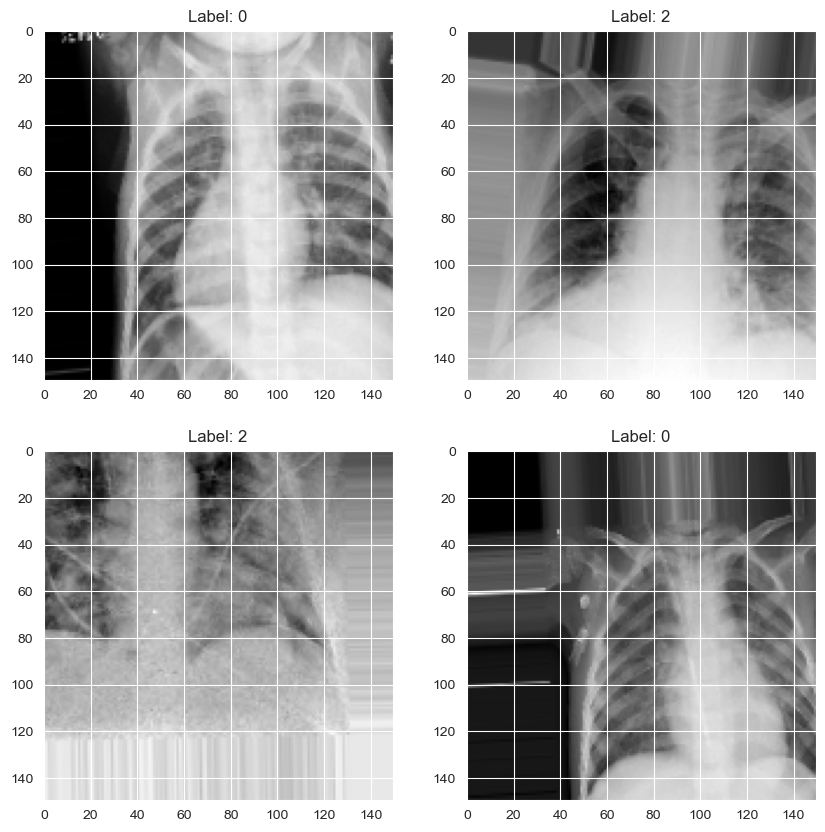

In [46]:
# Display some augmented images for visualization
augmented_images, augmented_labels = next(datagen.flow(x_train, y_train, batch_size=4))

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(augmented_images[i].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Label: {augmented_labels[i]}")
plt.show()

# Adaptive Masking / Diaphragm Removal / Testing and Training the Model №1

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import visualkeras
import numpy as np

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming x_train, y_train, x_val, y_val, x_test, y_test are already defined
# Fit the data generator to the training data
datagen.fit(x_train)

# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPool2D((2, 2), padding='same'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2), padding='same'),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2), padding='same'),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2), padding='same'),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Change to softmax for multiclass classification
])

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, reduce_lr]
                   )

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

C:\Users\hp pc\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\hp pc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 534ms/step - accuracy: 0.5825 - loss: 1.5511 - val_accuracy: 0.5166 - val_loss: 0.9645 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 519ms/step - accuracy: 0.7009 - loss: 0.8240 - val_accuracy: 0.7450 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 468ms/step - accuracy: 0.7191 - loss: 0.7324 - val_accuracy: 0.7341 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 456ms/step - accuracy: 0.7224 - loss: 0.7119 - val_accuracy: 0.7659 - val_loss: 0.7027 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 0.7563 - loss: 0.6489 - val_accuracy: 0.8501 - val_loss: 0.4332 - learning_rate: 1.0000e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - accuracy: 0.7720 - loss: 0.6000 - val_accuracy: 0.7442 - val_loss: 0.7311 - learning_rate: 1.0000e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 451ms/step - 

# Plots and Graphs of results

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


<Figure size 1000x1000 with 0 Axes>

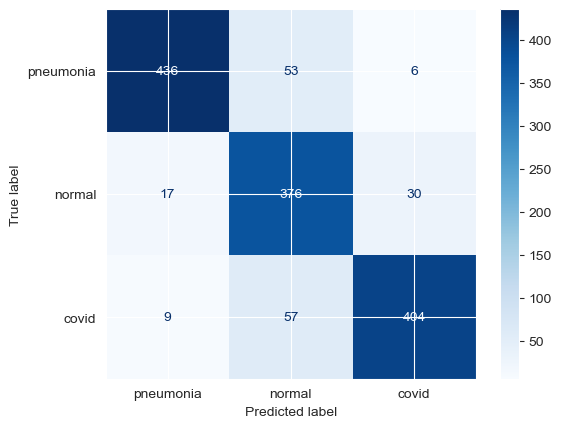

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['pneumonia', 'normal', 'covid'])

# Plot confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

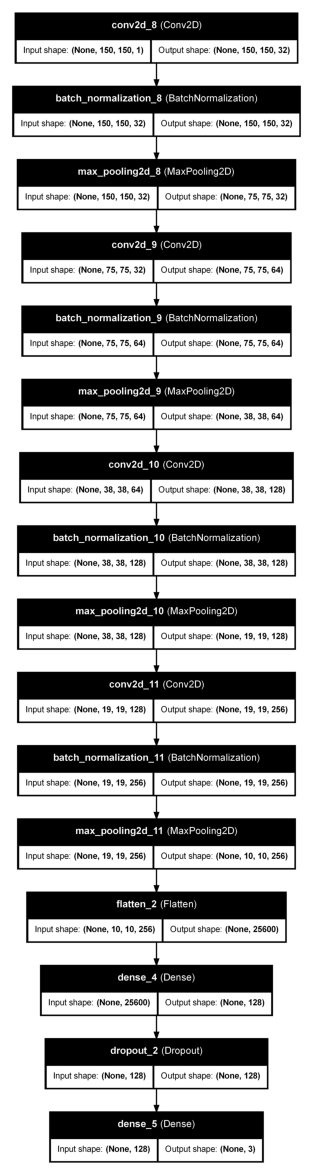

In [53]:
import matplotlib.image as mpimg
# Plotting the model architecture and saving it as a high-resolution PNG
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=300)

# Reading and displaying the high-resolution plot
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
plt.imshow(img)
plt.axis('off')
plt.savefig('myplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

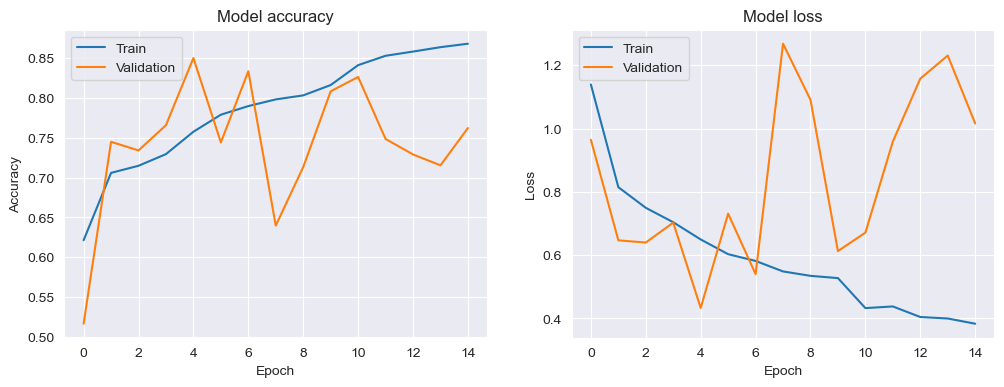

In [57]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()